# TP Module 6 : La segmentation

## Import libs

In [0]:
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(keras.__version__)

import matplotlib.pyplot as plt
import pandas as pd
import random
import os
import numpy as np

# freeze de l'aléatoire, pour avoir des expériences reproductibles.
RANDOM_SEED = 42

os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.random.set_seed(RANDOM_SEED)

2.2.0
2.3.0-tf


In [0]:
!nvidia-smi

Wed May 27 13:55:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    33W / 250W |    357MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import GlobalAvgPool2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose

from tensorflow.keras import Model

## Les datasets & les métriques appropriés

### Nucleus

In [0]:
!unzip -q nucleus.zip -d nucleus_dir

In [0]:
x_train_dir = '/content/nucleus_dir/data/train/'
y_train_dir = '/content/nucleus_dir/data/train/solutions/'

x_test_dir = '/content/nucleus_dir/data/test/'
y_test_dir = '/content/nucleus_dir/data/test/solutions/'

input_size = (224, 224)

import glob
from PIL import Image

def load_image(path): 
  return np.asarray(Image.open(path).resize(input_size, Image.NEAREST))

def load_dir(dir):
  img_paths = glob.glob(dir+'*.png')
  img_arr = np.array([load_image(p) for p in img_paths])
  return img_arr

Seul le jeu d'entraînement et le jeu de test ont les masques. On tuilisera donc le jeu de test comme jeu de validation.

In [0]:
x_train = load_dir(x_train_dir)
print('x_train shape', x_train.shape)
y_train = load_dir(y_train_dir)
print('y_train shape', y_train.shape)

x_test = load_dir(x_test_dir)
print('x_test shape', x_test.shape)
y_test = load_dir(y_test_dir)
print('y_test shape', y_test.shape)

x_train shape (555, 224, 224)
y_train shape (555, 224, 224)
x_test shape (42, 224, 224)
y_test shape (42, 224, 224)


In [0]:
x_train = tf.reshape(x_train, (-1, 224,224,1))
y_train = tf.reshape(y_train, (-1, 224,224,1))
x_test = tf.reshape(x_test, (-1, 224,224,1))
y_test = tf.reshape(y_test, (-1, 224,224,1))

x_train = x_train/ 255
y_train = y_train/ 255
x_test = x_test/ 255
y_test = y_test/ 255

In [0]:
ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(buffer_size=len(x_train)).batch(16)
ds_val = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(buffer_size=len(x_test)).batch(16)

Voyons à quoi cela ressemble.

Populating the interactive namespace from numpy and matplotlib


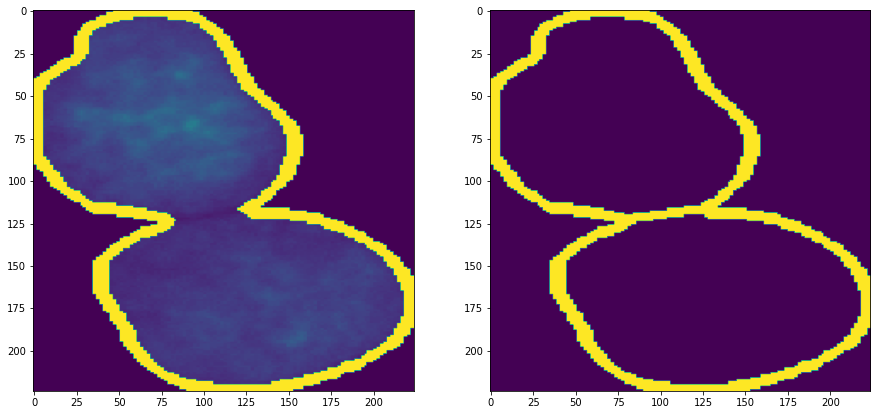

In [0]:
%pylab inline

obs = 1

figsize(15,15)
subplot(1, 2, 1)
imshow(x_train[obs, :, :, 0])
subplot(1, 2, 2)
imshow(y_train[obs, :, :, 0])

### CamVid

Le dataset présenté ici est le dataset communément nommé **CamVid**, pour **Cambridge-driving Labeled Video Database**, c'est un dataset souvent utilisé pour le benchmark de modèle en segmentation sémantique.

Le Dataset se compose de photos prises du point de vue d'un conducteur de voiture, ce qui en fait un bon point de départ pour les modèles par exemple utilisés dans les voitures autonomes.

Attention ne vous leurrez pas, les voitures autonomes par exemple chez Tesla, fonctionnent grâce à la combinaison de 90 modèles de deep learning différents, le tout cumulant 75000h d'entraînements au minimum. Mais cela reste un point de départ.

In [0]:
!git clone https://github.com/alexgkendall/SegNet-Tutorial.git

!mkdir /data
!mkdir /data/datasets/
!mv /content/SegNet-Tutorial/ /data/datasets/

fatal: destination path 'SegNet-Tutorial' already exists and is not an empty directory.
mkdir: cannot create directory ‘/data’: File exists
mkdir: cannot create directory ‘/data/datasets/’: File exists
mv: cannot move '/content/SegNet-Tutorial/' to '/data/datasets/SegNet-Tutorial': Directory not empty


In [0]:
input_size = (224, 224)

In [0]:
base = '/data/datasets/SegNet-Tutorial/CamVid/'

x_train = load_dir(base+'train/')
print('x_train shape', x_train.shape)
y_train = load_dir(base+'trainannot/')
print('y_train shape', y_train.shape)

x_val = load_dir(base+'val/')
print('x_val shape', x_val.shape)
y_val = load_dir(base+'valannot/')
print('y_val shape', y_val.shape)

x_test = load_dir(base+'test/')
print('x_test shape', x_test.shape)
y_test = load_dir(base+'testannot/')
print('y_test shape', y_test.shape)

x_train shape (367, 224, 224, 3)
y_train shape (367, 224, 224)
x_val shape (101, 224, 224, 3)
y_val shape (101, 224, 224)
x_test shape (233, 224, 224, 3)
y_test shape (233, 224, 224)


La Dataset contient au total $701$ images annotées **à la main**.  Les annotations dans y correspondent à un masque : chaque pixel à une classe qui lui est défini, il y a en tout 32 classes dans ce dataset.  Les classes sont les suivantes :

- VegetationMisc
- SignSymbol
- Column_Pole
- Child
- Truck_Bus
- Train
- MotorcycleScooter
- Archway
- LaneMkgsNonDriv
- RoadShoulder
- Sky
- Misc_Text
- Tree
- Road
- OtherMoving
- LaneMkgsDriv
- Building
- ParkingBlock
- Wall
- SUVPickupTruck
- Animal
- Fence
- Pedestrian
- CartLuggagePram
- Car
- Tunnel
- Bicyclist
- Bridge
- TrafficLight
- Sidewalk
- TrafficCone
- Void

et chaque classe est réprésentée par une combinaison RGB différente :

```python
192 192 0	  VegetationMisc
192 128 128	SignSymbol
192 192 128	Column_Pole
192 128 64	 Child
192 128 192	Truck_Bus
192 64 128	 Train
192 0 192	  MotorcycleScooter
192 0 128	  Archway
192 0 64	   LaneMkgsNonDriv
128 128 192	RoadShoulder
128 128 128	Sky
128 128 64	 Misc_Text
128 128 0	  Tree
128 64 128	 Road
128 64 64	  OtherMoving
128 0 192	  LaneMkgsDriv
128 0 0		Building
64 192 128 	ParkingBlock
64 192 0	   Wall
64 128 192	 SUVPickupTruck
64 128 64	  Animal
64 64 128	  Fence
64 64 0	    Pedestrian
64 0 192	   CartLuggagePram
64 0 128	   Car
64 0 64		Tunnel
0 128 192	  Bicyclist
0 128 64	   Bridge
0 64 64		TrafficLight
0 0 192		Sidewalk
0 0 64		 TrafficCone
0 0 0		  Void
```

Les classes sont dans l'ordre et commencent à $1$. Par exemple, la classe "Sky" est représentée dans le masque par l'entier $11$.

Voyons à quoi cela ressemble.

Populating the interactive namespace from numpy and matplotlib


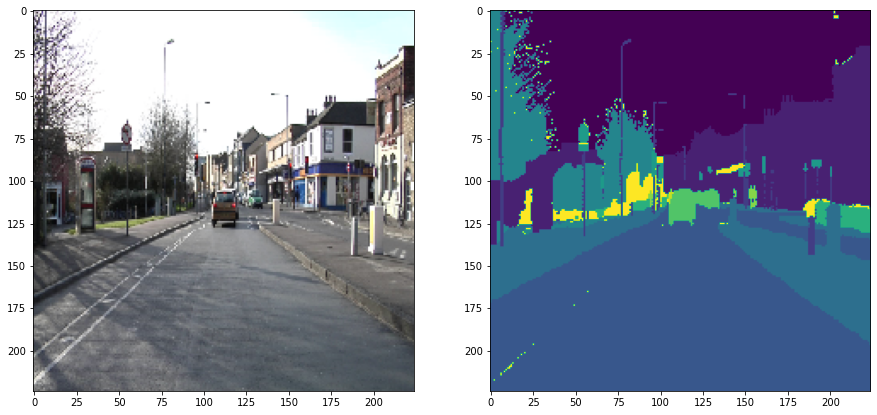

In [0]:
%pylab inline

obs = 350

figsize(15,15)
subplot(1, 2, 1)
imshow(x_train[obs])
subplot(1, 2, 2)
imshow(y_train[obs, :, :])

Le but d'un modèle de segmentation sémantique est donc de prédire la classe de chaque pixels. Finalisons nos datasets.

In [0]:
x_train = x_train / 255
x_val = x_val / 255
x_test = x_test / 255

In [0]:
ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(buffer_size=len(x_train)).batch(3)
ds_val = tf.data.Dataset.from_tensor_slices((x_val, y_val)).shuffle(buffer_size=len(x_val)).batch(3)
ds_test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(buffer_size=len(x_test)).batch(3)

### IoU métrique

Concernant les métriques spécifiques au problèmes de la segmentation, nous en avaons en particuliers deux : 

- Dice Coefficient :
$$\text{DC} = \frac{2 TP}{2 TP + FP + FN} = \frac{2|X \cap Y|}{|X| + |Y|}$$

- Intersection over Union :
$$\text{IoU} = \frac{TP}{TP + FP + FN} = \frac{|X \cap Y|}{|X| + |Y| - |X \cap Y|}$$

Par définition, on voit que $\text{DC} \geq \text{IoU}$.

## La convolution transposée

Générons une feature map aléatoire.

In [0]:
fm  = np.random.random(1*256*256*3).astype('float32')
fm = tf.reshape(fm, (-1,256,256,3))
fm.shape

TensorShape([1, 256, 256, 3])

Une convolution classique, avec un `stride=1`, et un `padding='same'` ne change pas la dimension de `fm`.

In [0]:
conv = Conv2D(3, kernel_size=3, strides=1, padding='same')
fm_out = conv(fm)
fm_out.shape

TensorShape([1, 256, 256, 3])

Mais une convolution avec un `stride=1`, `padding='same'` elle change la dimension de `fm`, en la divisant par 2.

Dans le cas où `padding=same`, la dimension de sortie $o$ est complètement déterminée par le stride et la dimension d'entrée $i$, avec la formule suivante.

$$o = \left\lceil \frac{i}{s} \right\rceil$$

In [0]:
conv2 = Conv2D(3, kernel_size=3, strides=2, padding='same')
fm_out2 = conv2(fm)
fm_out2.shape

TensorShape([1, 128, 128, 3])

Pour la convolution transposée, comme cette opération est la contrepartie arrière d'une convolution normale, cela signifie que la dimension de sortie d'une convolution normale correspond à la dimension d'entrée de la convolution transposée. En d'autres termes, alors que la forme de sortie de `Conv2D()` est divisée par le stride, la dimension de sortie de `Conv2DTranspose()` est multipliée par celui-ci.

$$o=s\cdot i$$

In [0]:
convT = Conv2DTranspose(3, kernel_size=3, strides=2, padding='same')
fm2 = convT(fm_out2)
fm2.shape

TensorShape([1, 256, 256, 3])

Attention, comme dit prcédemment, on ne récupère que la dimension, on ne récupère évidemment pas les valeurs initiales de `fm`.

In [0]:
np.sum((fm==fm2).numpy(), axis=(0,1,2,3))

0

## Unet

Unet est l'un des premiers réseaux de neurones généralisant les "skip connections" de l'architecture ResNet pour la segmentation sémantique. Il a été à la base développé pour des problèmes de médecines, ie donner une classification des différents types de cellules dans une boite de Petri. L'article d'origine n'avait un jeu de donnée que d'une cinquantaine d'images de boites de Petri différentes, et pourtant il a largement surpassé l'état de l'art comtemporain.

### Idée

- However, in many visual tasks, especially in biomedical image processing, the desired output should include localization, i.e. a class label is supposed to be assigned to each pixel. **Moreover, thousands of training images are usually beyond reach in biomedial tasks**.

- The main idea [...] is to supplement a usual contracting network by successive layers, where pooling operators are replaced by upsampling operators. Hence these layers increase the resolution of the output. In order to localize, high resolution features from the contracting path are combined with the upsampled output.

- The network does not have any fully connected layers and only uses [..] convolution [...].

- It consists of a contracting path (left side) and an expensive path (right side)

### Les briques de bases

##### Downsampling

- The contracting path follows the typical architecture of a convolutional network. It consists of the repeated application of two $3 \times 3$ convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a $2 \times 2$ max pooling operation with strides $2$. for downsampling.

- At each downsampling step we double the number of features channels.

In [0]:
def conv_relu(tensor, filters):
  x = Conv2D(filters,
             kernel_size=(3,3),
             strides=(1,1),
             padding='same',
             kernel_initializer='he_normal')(tensor)
  x = ReLU()(x)
  x = Conv2D(filters,
             kernel_size=(3,3),
             strides=(1,1),
             padding='same',
             kernel_initializer='he_normal')(x)
  x = ReLU()(x)

  return x

In [0]:
def downsample(tensor):
  x = MaxPool2D(pool_size=(2,2),
                strides=(2,2))(tensor)

  return x

##### Upsampling

- Every step in the expansive path consists of an upsampling of the feature map followed by a $2 \times 2$ convolution ("up-convolution") that halves the number of feature channels.

- A concatenation with the correspondingly cropped feature map from the contracting path, and two $3 \times 3$ convolutions, each followed by a ReLU.

In [0]:
def upsample(tensor, filters):
  x = Conv2DTranspose(filters = filters,
                      kernel_size = 2,
                      strides = (2, 2),
                      padding = "same",
                      kernel_initializer = 'he_normal')(tensor)
  
  return x 

##### Final layer

- At the final layer a $1 \times 1$ convolution is used to map each $64$-component feature vector to the desired number of classes.

- In total the network has $23$ convolutional layers.

#### Mise en place du modèle


In [0]:
def get_unet(filters, num_classes, img_shape):

  growth_rate = [filters, 2*filters, 4*filters, 8*filters, 16*filters, 8*filters, 4*filters, 2*filters, filters]
  nb_blocks = 4
  upsampling_fm = []

  # input block
  input = Input(shape=img_shape)
  x = input

  #downsampling blocks
  for i in range(nb_blocks):
    x = conv_relu(x, growth_rate[i])
    upsampling_fm.append(x)
    x = downsample(x)

  # Bottleneck
  upsampling = upsampling_fm[::-1]
  x = conv_relu(x, growth_rate[4])

  #upsampling path
  for i in range(nb_blocks):
    x = upsample(x, growth_rate[5+i])
    x = Concatenate()([x, upsampling[i]])
    x = conv_relu(x, growth_rate[i])

  outputs =  Conv2D(num_classes,
                    kernel_size=(1,1),
                    strides=(1,1),
                    kernel_initializer='he_normal',
                    activation='sigmoid')(x) 

  model = Model(input, outputs)

  return model

In [0]:
filters = 32
num_classes = 1
img_shape = (224, 224, 1)

model = get_unet(filters, num_classes, img_shape)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 224, 224, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
re_lu_18 (ReLU)                 (None, 224, 224, 32) 0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 224, 224, 32) 9248        re_lu_18[0][0]                   
____________________________________________________________________________________________

In [0]:
img = tf.reshape(x_train[0, :, :], (-1, 224,224, 1))
p = model(img)
p.shape

TensorShape([1, 224, 224, 1])

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.RMSprop(),
              metrics=["accuracy"])

In [0]:
history = model.fit(x_train, y_train,
                    epochs=100,
                    batch_size=16,
                    validation_split=0.1)

Epoch 1/100
32/32 [==============================] - 21s 658ms/step - loss: 0.0083 - accuracy: 0.9965 - val_loss: 0.0279 - val_accuracy: 0.9912
Epoch 2/100
32/32 [==============================] - 21s 657ms/step - loss: 0.0092 - accuracy: 0.9961 - val_loss: 0.0309 - val_accuracy: 0.9905
Epoch 3/100
32/32 [==============================] - 21s 656ms/step - loss: 0.0126 - accuracy: 0.9952 - val_loss: 0.0240 - val_accuracy: 0.9924
Epoch 4/100
32/32 [==============================] - 21s 657ms/step - loss: 0.0077 - accuracy: 0.9967 - val_loss: 0.0328 - val_accuracy: 0.9918
Epoch 5/100
32/32 [==============================] - 21s 657ms/step - loss: 0.0082 - accuracy: 0.9965 - val_loss: 0.0578 - val_accuracy: 0.9924
Epoch 6/100
32/32 [==============================] - 21s 656ms/step - loss: 0.0077 - accuracy: 0.9967 - val_loss: 0.0270 - val_accuracy: 0.9910
Epoch 7/100
32/32 [==============================] - 21s 657ms/step - loss: 0.0073 - accuracy: 0.9969 - val_loss: 0.0460 - val_accuracy:

Populating the interactive namespace from numpy and matplotlib


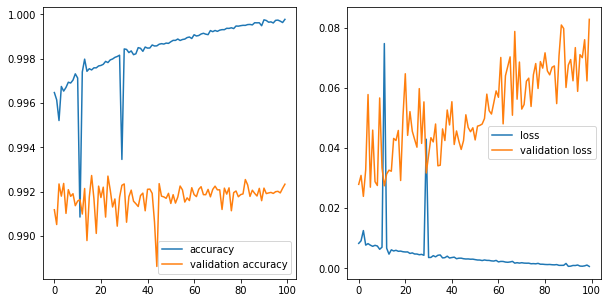

In [0]:
%pylab inline
figsize(10, 5)

subplot(1, 2, 1)
plot(history.history['accuracy'], label='accuracy')
plot(history.history['val_accuracy'], label='validation accuracy')
legend()

subplot(1, 2, 2)
plot(history.history['loss'], label='loss')
plot(history.history['val_loss'], label='validation loss')

legend()
show()

In [0]:
model.save('unet_nucleus_100_epochs.h5')

In [0]:
img = tf.reshape(x_train[num_obs], (-1, 224, 224))
p = model.predict(img)
p.shape

(1, 224, 224, 1)

#### Prédiction

Populating the interactive namespace from numpy and matplotlib


Text(0.5, 0, 'Vérité')

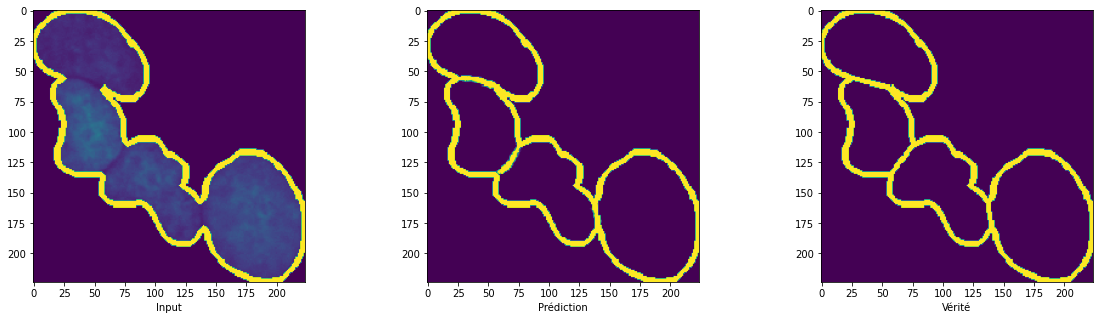

In [0]:
%pylab inline
num_obs=13

img = tf.reshape(x_test[num_obs], (-1, 224, 224))
p = model.predict(img)
p.shape

figsize(20, 5)

subplot(1, 3, 1)
imshow(img[0, :, :,])
xlabel('Input')

subplot(1, 3, 2)
imshow(p[0, :, :, 0])
xlabel('Prédiction')

subplot(1, 3, 3)
imshow(y_test[num_obs][:, :, 0])
xlabel('Vérité')

#m = tf.keras.metrics.MeanIoU(num_classes=2)
#m(y_train[num_obs][:, :], p[0, :, :]).numpy()

#### MeanIoU via custom training loop

In [0]:
epochs = 150
loss_fn = tf.keras.losses.BinaryCrossentropy()
metric_fn = tf.keras.metrics.MeanIoU(num_classes=2)
optimizer = tf.keras.optimizers.RMSprop(lr=1e-3)

@tf.function
def train_step(x, y):
  with tf.GradientTape() as tape:
    #prédiction sur le minibatch
    y_pred = model(x, training=True)
    #calcul de la fonction de perte moyenne sur le minibatch
    loss_value = loss_fn(y, y_pred)

  # calcul des gradients et retropropagation
  grads = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(grads, model.trainable_weights))

  # mise à jour des métriques
  metric_fn.update_state(y, y_pred)

  return loss_value

@tf.function
def test_step(x, y):
  y_pred = model(x, training=False)
  loss_value = loss_fn(y, y_pred)
  metric_fn.update_state(y, y_pred)

  return loss_value

for epoch in range(epochs):
  losses = 0 
  step_counter = 0
  print(f"\nDébut de l'époque {epoch+1},")
  start_time = time.time()

  # itération sur les minibatchs du dataset
  for step, (x_batch_train, y_batch_train) in enumerate(ds):
    loss_value = train_step(x_batch_train, y_batch_train)
    losses += loss_value
    step_counter += 1

    # Log tous les 10 batches
    if step % 10 == 0:
      print(f"Loss sur le batch à l'étape {step} : {float(loss_value):.4f}")

  # Affichage des métriques à la fin de l'époque
  metric = metric_fn.result()
  print()
  print(f"Loss : {losses/step_counter:.4f}")
  print(f"Métrique pour l'époque : {float(metric):.4f} \n")
    
  # Reset de la métrique à la fin de chaque époque
  metric_fn.reset_states()

  # validation loop à la fin de chaque époque
  for x_batch_val, y_batch_val in ds_val:
    val_loss = test_step(x_batch_val, y_batch_val)

  val_metric = metric_fn.result()
  metric_fn.reset_states()
  print()
  print(f"Loss de validation : {float(val_loss):.4f}")
  print(f"Métrique de validation : {float(val_metric):.4f}")
  print(f"Durée de l'époque: {time.time() - start_time:.2fs}")


Début de l'époque 1,
Loss sur le batch à l'étape 0 : 7.0191
Loss sur le batch à l'étape 10 : 0.0430
Loss sur le batch à l'étape 20 : 0.0293
Loss sur le batch à l'étape 30 : 0.0351

Loss pour l'époque 1: 0.2819
Métrique pour l'époque : 0.4788 

Métrique de validation : 0.4605
Time taken: 49.55s

Début de l'époque 2,
Loss sur le batch à l'étape 0 : 0.0332
Loss sur le batch à l'étape 10 : 0.0199
Loss sur le batch à l'étape 20 : 0.0218
Loss sur le batch à l'étape 30 : 0.0270

Loss pour l'époque 2: 0.0278
Métrique pour l'époque : 0.4580 

Métrique de validation : 0.4872
Time taken: 45.75s

Début de l'époque 3,
Loss sur le batch à l'étape 0 : 0.0195
Loss sur le batch à l'étape 10 : 0.0333
Loss sur le batch à l'étape 20 : 0.0358
Loss sur le batch à l'étape 30 : 0.0282

Loss pour l'époque 3: 0.0322
Métrique pour l'époque : 0.4840 

Métrique de validation : 0.4672
Time taken: 46.34s

Début de l'époque 4,
Loss sur le batch à l'étape 0 : 0.0168
Loss sur le batch à l'étape 10 : 0.0549
Loss sur le

In [0]:
model.save('unet_nucleus_150_epochs.h5')

## Tiramisu

### Idée

Recently, a new CNN architecture, Densely connected Convolutional Networks (DenseNets), has shown excellent results on image classification tasks. The idea of DenseNets is based on the observation that if each layer is directly connected to every other layer in a **feed-forward fashion** then the network will be more accurate and easier to train.

In this paper, we extend DenseNets to deal with the problem of semantic segmentation.

### Les briques de bases

- we extend DenseNets to work as FCNs by adding an upsampling path to recover the full resoluution.
- we *only* upsample the feature maps created the preceding dense block.
- The higher resolution information is passed by means of a standard skip connection between the downsampling and the upsampling paths. The details of the proposed architecture are shown in Figure 1. 

#### Les layers denses

$$x_{\ell} := H([x_{\ell-1}, x_{\ell-2}, \dots, x_{0}])$$

- $H$ is defined as BN-ReLu-Conv($3 \times 3$)-Dropout($p=0.2$).
- The outpout dimension of each layer $\ell$ has $k$ features, hereafter referred as to *growth rate* parameter.

In [0]:
def bn_relu_conv(tensor, filters, kernel_size):
  x = BatchNormalization()(tensor)
  x = ReLU()(x)
  x = Conv2D(filters,
             kernel_size=kernel_size,
             strides=1,
             padding='same',
             kernel_initializer='he_uniform'
             )(x)
  x = Dropout(0.2)(x)

  return x

- Dense block layers are composed of BN, followed by a ReLU, a $3\times3$ same convolution (no resolution loss) and dropout with probability $p=0.2$.

In [0]:
def dense_layer(tensor, reps, filters):
  
  skip_connection = []
  #growth_rate = 0

  for i in range(reps-1):
    out_conv = bn_relu_conv(tensor, filters, 3)
    #growth_rate += filters
    tensor = Concatenate()([tensor, out_conv])
    skip_connection.append(out_conv)

  
  out_conv = bn_relu_conv(tensor, filters, 3)
  skip_connection.append(out_conv)
  #pour les avoir dans le bon ordre [x_{l-1}, x_{l-2}, ..., x_{0}]
  skip_connection = skip_connection[::-1]
  x = Concatenate()(skip_connection)

  return x

Vérifions à quoi ressemble le bloc dense que nous avons écrit. On peut le visualiser avec l'option `plot_model` de `tf.keras`.

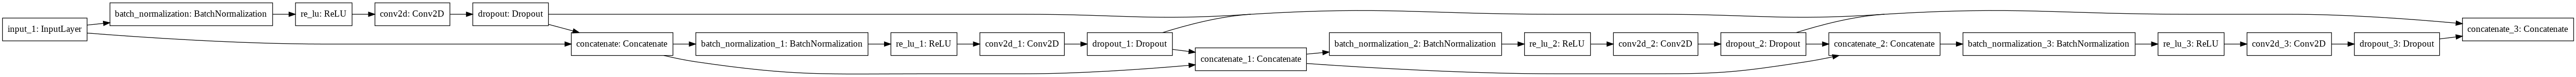

In [0]:
IMG_SHAPE = 32, 32, 3


input = Input(IMG_SHAPE)
output = dense_layer(input, 4, 16)

model = Model(input, output)
tf.keras.utils.plot_model(model,rankdir='LR')

Vérifions si l'on a le bon nombre de feature map à la fin de chaque bloc dense, sur le chemin contractant. Les Conv($1 \times 1$) des blocs de transition down ne changeant pas le nombre de feature maps, on ne les rajoute pas ici.

In [0]:
filters = 16
#downsampling path
reps = [4, 5, 7, 10, 12]
f = 48
f_size_d=[]

for k in reps:
  c = np.random.random_sample(32*32*f).astype('float32')
  c = tf.reshape(c,(-1,32,32, f))
  out = dense_layer(c, k, filters)
  out = Concatenate()([out,c])
  f_size_d.append(out.shape[3])  
  f = out.shape[3]

print(f_size_d)

[112, 192, 304, 464, 656, 896, 1088]


#### Transition down

- A *transition down* is introduced to reduce the spatial dimensionality of the feature maps. Such transformation is composed of a $1\times1$ convolution (which conserves the number of feature maps) followed by a $2 \times 2$ pooling operation.

- Transition down is composed of BN, followed by a ReLU, a $1 \times 1$ convolution, dropout with $p=0.2$ and a non-overlapping max pooling of size $2 \times 2$.

In [0]:
def transition_down(tensor, filters):
  x = bn_relu_conv(tensor, filters, 1)
  x = MaxPool2D(pool_size=(2,2),
                strides=(2,2),
                padding='same')(x)

  return x

#### Transition up

- The transition up modules consist of a transpose convolution that upsamples the previous feature maps.
- Transition up is composed of a $3 \times 3$ transposed convolution with a stride of $2$.

In [0]:
def transition_up(tensor, filters):
  x = Conv2DTranspose(filters=filters,
                      kernel_size=3,
                      strides=(2, 2),
                      padding="same",
                      kernel_initializer='he_uniform')(tensor)
  
  return x

#### Mise en place du modèle

- The upsampled feature maps are then concatenated to the ones coming from the skip connection to form the input of a new dense block.

- In the upsampling path [...] the input of a danse block is not concatenated with its output. Thus, the transposed convolution is applied only to the feature map obtained by *the last dense blocks and not to all feature maps concatenated so far*.

- The *growth rate* of the layer is set to $k=16$.

In [0]:
def FCDensenet(filters, nb_layers, img_shape, num_classes, nb_blocks=5, nb_filters=48):

  nb_filters = 48
  upsampling_fm=[]

  # input block
  input = Input(shape=img_shape)
  x = Conv2D(nb_filters,
              kernel_size=3,
              strides=1,
              padding='same',
              kernel_initializer='he_uniform'
              )(input)

  #downsampling blocks
  for i in range(nb_blocks):
    out_conv = dense_layer(x, nb_layers[i], filters)
    out_conv = Concatenate()([out_conv, x])
    nb_filters += filters*nb_layers[i]
    
    upsampling_fm.append(out_conv)
    upsampling = upsampling_fm[::-1]
    x = transition_down(out_conv, nb_filters)

  # Bottleneck
  #print(f'bottleneck')
  x = dense_layer(x, nb_layers[5], filters)
  nb_filters = filters*nb_layers[5]
  #print(f'x : {x.shape}')


  #upsampling path
  for i in range(nb_blocks):
    #print(f'upsampling block {i}')
    #print(f'there will be {nb_layers[6+i]} layers')
    
    x = transition_up(x, nb_filters)
    #print(f'x upsampled : {x.shape}')
    #print(f'skip connection : {upsampling[i].shape}')
    x = Concatenate()([x, upsampling[i]])
    #print(f'x_before_dense : {x.shape}')
    
    if nb_layers[6+i]==nb_layers[-1]:
      #print('last layer')
      out_conv = dense_layer(x, nb_layers[6+i], filters)
      x = Concatenate()([out_conv, x])
      #print(f'x_after_dense : {x.shape}')
    else:
      x = dense_layer(x, nb_layers[6+i], filters)
      nb_filters = filters*nb_layers[6+i]

  # output block
  x = Conv2D(num_classes,
            kernel_size=1,
            strides=(1,1),
            padding='same',
            kernel_initializer='he_uniform')(x)
  x = Activation('softmax')(x)


  model = Model(input, x)

  return model

##### FC-Densenet103

In [0]:
filters = 16
nb_blocks = 5
nb_layers = [4, 5, 7, 10, 12 ,15, 12, 10, 7, 5, 4]
img_shape = (224,224,3)

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()
model = FCDensenet(filters, nb_layers, img_shape, num_classes=32)

In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 48) 1344        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 48) 192         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 224, 224, 48) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [0]:
p = model.predict(x_train[:1])
p.shape

(1, 224, 224, 32)

- Finally the model is trained by minimizing the pixel-wise cross-entropy loss.
- We [..] train them with RMSprop with an initial learning rate of $1e-3$.

In [0]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=keras.optimizers.RMSprop(lr=1e-3),
              metrics=["accuracy"])

In [0]:
history = model.fit(ds,
                    epochs=100,
                    validation_data=ds_val)

Epoch 1/100
123/123 [==============================] - 48s 393ms/step - loss: 1.7000 - accuracy: 0.5569 - val_loss: 9.1128 - val_accuracy: 0.3007
Epoch 2/100
123/123 [==============================] - 43s 351ms/step - loss: 1.1311 - accuracy: 0.6471 - val_loss: 1.6813 - val_accuracy: 0.5465
Epoch 3/100
123/123 [==============================] - 43s 351ms/step - loss: 0.8990 - accuracy: 0.7045 - val_loss: 1.8816 - val_accuracy: 0.4774
Epoch 4/100
123/123 [==============================] - 43s 351ms/step - loss: 0.7812 - accuracy: 0.7444 - val_loss: 0.8675 - val_accuracy: 0.6934
Epoch 5/100
123/123 [==============================] - 43s 351ms/step - loss: 0.7029 - accuracy: 0.7717 - val_loss: 1.2044 - val_accuracy: 0.6180
Epoch 6/100
123/123 [==============================] - 43s 351ms/step - loss: 0.6366 - accuracy: 0.7987 - val_loss: 1.9921 - val_accuracy: 0.5372
Epoch 7/100
123/123 [==============================] - 43s 351ms/step - loss: 0.5925 - accuracy: 0.8153 - val_loss: 0.7431 -

Populating the interactive namespace from numpy and matplotlib


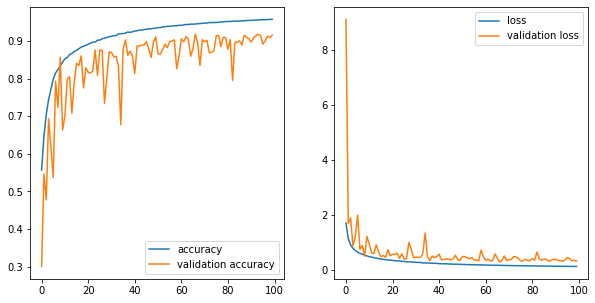

In [0]:
%pylab inline
figsize(10, 5)

subplot(1, 2, 1)
plot(history.history['accuracy'], label='accuracy')
plot(history.history['val_accuracy'], label='validation accuracy')
legend()

subplot(1, 2, 2)
plot(history.history['loss'], label='loss')
plot(history.history['val_loss'], label='validation loss')

legend()
show()

In [0]:
model.save('fc_densenet_103_camvid_100epochs.h5')

In [0]:
 model.evaluate(x_test, y_test)

8/8 [==============================] - 6s 747ms/step - loss: 0.6612 - accuracy: 0.8556


[0.6612146496772766, 0.855552077293396]

La liste des classes et des couleurs attenantes est à l'adresse http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/data/label_colors.txt

Interact labeller pour la segmentation

http://mi.eng.cam.ac.uk/projects/cvgroup/software/index.html

"The training images were hand-labeled with the assigned colors acting as indices into the list of object classes."

In [0]:
colors = [(192, 192, 128),	
(192, 192, 0),
(192, 128, 192),
(192, 128, 128),
(192, 128, 64),
(192, 64, 128),	
(192, 0, 192),	 
(192, 0, 128),
(192, 0, 64),
(128, 128, 192),
(128, 128, 128),
(128, 128, 64),
(128, 128, 0),
(128, 64, 128),
(128, 64, 64),  
(128, 0, 192),	  
(128, 0, 0),  
(64, 192, 128),	
(64, 192, 0),
(64, 128, 192),
(64, 128, 64),  
(64, 64, 128),	  
(64, 64, 0), 
(64, 0, 192),	  
(64, 0, 128),
(64, 0, 64),
(0, 128, 192),
(0, 128, 64),
(0, 64, 64),
(0, 0, 192),
(0, 0, 64),
(0, 0, 0)]

In [0]:
class_weights = {0 : 9.60606490919,
1 :	9.77766487673,
2 :	10.0194993159,
3 :	10.3749043447,
4 : 10.4631076496,
5 :	10.4920586873,
6 :	10.4839211216,
7 :	10.4356039685,
8 :	10.4757462996,
9 : 10.2342992955,
10 : 4.3720296426,
11 : 9.94147719336,
12 : 5.43594061016,
13 : 3.15728309302,
14 : 10.1258833847,
15 : 9.08285926082,
16 : 3.47796865386,
17 : 10.1577327692,
18 : 9.32269173889,
19 :	9.7926997517,
20 :	10.4870856376,
21 :	9.26646394904,
22 :	9.88371158915,
23 :	10.4613353846,
24 : 	7.95097080927,
25 :	10.4920560223,
26 :	9.99897358787,
27 : 	10.4371404226,
28 :	10.1479245421,
39 :	6.58893008318,
30 :	10.4882678542,
31 :	8.19641542163}

In [0]:
img = tf.reshape(x_train[75], (-1, 224, 224, 3))
p = model.predict(img)
p = np.argmax(p, axis=-1)
p.shape

(1, 224, 224)

In [0]:
from tensorflow.keras.models import load_model

model = load_model('fc_densenet_103_camvid_100epochs.h5')

##### Prédiction

0.7309558

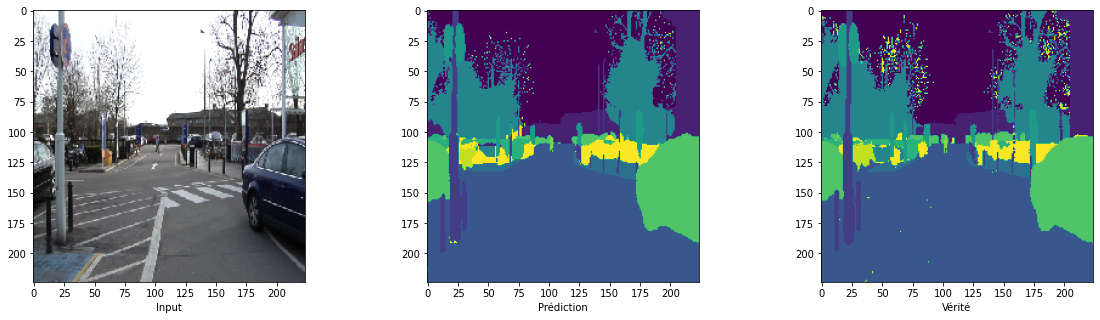

In [0]:
num_obs=240

img = tf.reshape(x_train[num_obs], (-1, 224, 224, 3))
p = model.predict(img)
p = np.argmax(p, axis=-1)
p.shape

figsize(20, 5)

subplot(1, 3, 1)
imshow(img[0, :, : ,:])
xlabel('Input')

subplot(1, 3, 2)
imshow(p[0, :, :])
xlabel('Prédiction')

subplot(1, 3, 3)
imshow(y_train[num_obs][:, :])
xlabel('Vérité')

m = tf.keras.metrics.MeanIoU(num_classes=32)
m(y_train[num_obs][:, :], p[0, :, :]).numpy()

##### MeanIoU via custom training loop

In [0]:
epochs = 150
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
metric_fn = tf.keras.metrics.MeanIoU(num_classes=32)
optimizer = tf.keras.optimizers.RMSprop(lr=1e-3)

@tf.function
def train_step(x, y):
  with tf.GradientTape() as tape:
    #prédiction sur le minibatch
    y_pred = model(x, training=True)
    #calcul de la fonction de perte moyenne sur le minibatch
    loss_value = loss_fn(y, y_pred)

  # calcul des gradients et retropropagation
  grads = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(grads, model.trainable_weights))

  # mise à jour des métriques
  mask_pred = tf.argmax(y_pred, axis=-1)
  metric_fn.update_state(y, mask_pred)

  return loss_value

@tf.function
def test_step(x, y):
  y_pred = model(x, training=False)
  mask_pred = tf.argmax(y_pred, axis=-1)
  metric_fn.update_state(y, mask_pred)

for epoch in range(epochs):
  losses = 0 
  step_counter = 0
  print(f"\nDébut de l'époque {epoch+1},")
  start_time = time.time()

  # itération sur les minibatchs du dataset
  for step, (x_batch_train, y_batch_train) in enumerate(ds):
    loss_value = train_step(x_batch_train, y_batch_train)
    losses += loss_value
    step_counter += 1

    # Log tous les 100 batches
    if step % 100 == 0:
      print(f"Loss sur le batch à l'étape {step} : {float(loss_value):.4f}")

  # Affichage des métriques à la fin de l'époque
  metric = metric_fn.result()
  print(f"Loss pour l'époque : {losses/step_counter:.4f}")
  print(f"Métrique pour l'époque : {float(metric):.4f} \n")
    
  # Reset de la métrique à la fin de chaque époque
  metric_fn.reset_states()

  # validation loop à la fin de chaque époque
  for x_batch_val, y_batch_val in val_dataset:
    test_step(x_batch_val, y_batch_val)

  val_metric = metric_fn.result()
  metric_fn.reset_states()
  print("Validation acc: %.4f" % (float(val_metric),))
  print("Time taken: %.2fs" % (time.time() - start_time))

##### FC-Densenet56

- 56 layers (FC-DenseNet56) with $4$ layers par dense blocks and a growth rate of $12$.

In [0]:
#fc-densenet 56
filters = 12
nb_blocks = 5
nb_layers = [4, 4, 4, 4, 4 ,4, 4, 4, 4, 4, 4]
img_shape = (224,224,3)

model2 = FCDensenet(filters, nb_layers, img_shape, num_classes=32)
model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_200 (Conv2D)             (None, 224, 224, 48) 1344        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_194 (BatchN (None, 224, 224, 48) 192         conv2d_200[0][0]                 
__________________________________________________________________________________________________
re_lu_194 (ReLU)                (None, 224, 224, 48) 0           batch_normalization_194[0][0]    
____________________________________________________________________________________________

In [0]:
epochs = 150
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
metric_fn = tf.keras.metrics.MeanIoU(num_classes=32)
optimizer = tf.keras.optimizers.RMSprop(lr=1e-3)

@tf.function
def train_step(x, y):
  with tf.GradientTape() as tape:
    #prédiction sur le minibatch
    y_pred = model2(x_batch_train, training=True)
    #calcul de la fonction de perte moyenne sur le minibatch
    loss_value = loss_fn(y_batch_train, y_pred)

  # calcul des gradients et retropropagation
  grads = tape.gradient(loss_value, model2.trainable_weights)
  optimizer.apply_gradients(zip(grads, model2.trainable_weights))

  # mise à jour des métriques
  mask_pred = tf.argmax(y_pred, axis=-1)
  metric_fn.update_state(y_batch_train, mask_pred)

  return loss_value


for epoch in range(epochs):
  losses = 0 
  step_counter = 0
  print(f"\nDébut de l'époque {epoch+1},")
  start_time = time.time()

  # itération sur les minibatchs du dataset
  for step, (x_batch_train, y_batch_train) in enumerate(ds):
    loss_value = train_step(x_batch_train, y_batch_train)
    losses += loss_value
    step_counter += 1

    # Log tous les 100 batches
    if step % 100 == 0:
      print(f"Loss sur le batch à l'étape {step} : {float(loss_value):.4f}")

  # Affichage des métriques à la fin de l'époque
  metric = metric_fn.result()
  print(f"Loss pour l'époque : {losses/step_counter:.4f}")
  print(f"Métrique pour l'époque : {float(metric):.4f} \n")
    
  # Reset de la métrique à la fin de chaque époque
  metric_fn.reset_states()


Début de l'époque 1,
Loss sur le batch à l'étape 0 : 6.2236
Loss sur le batch à l'étape 100 : 0.1210
Loss pour l'époque : 0.5069 

Métrique pour l'époque : 0.5838 


Début de l'époque 2,
Loss sur le batch à l'étape 0 : 1.7736
Loss sur le batch à l'étape 100 : 0.0305
Loss pour l'époque : 0.0815 

Métrique pour l'époque : 0.9157 


Début de l'époque 3,
Loss sur le batch à l'étape 0 : 1.1833
Loss sur le batch à l'étape 100 : 0.0114
Loss pour l'époque : 0.0406 

Métrique pour l'époque : 0.9635 


Début de l'époque 4,
Loss sur le batch à l'étape 0 : 0.7455
Loss sur le batch à l'étape 100 : 0.0044
Loss pour l'époque : 0.0229 

Métrique pour l'époque : 0.9824 


Début de l'époque 5,
Loss sur le batch à l'étape 0 : 0.6260
Loss sur le batch à l'étape 100 : 0.0023
Loss pour l'époque : 0.0155 

Métrique pour l'époque : 0.9891 


Début de l'époque 6,
Loss sur le batch à l'étape 0 : 0.2041
Loss sur le batch à l'étape 100 : 0.0014
Loss pour l'époque : 0.0118 

Métrique pour l'époque : 0.9902 


Déb

0.42460242

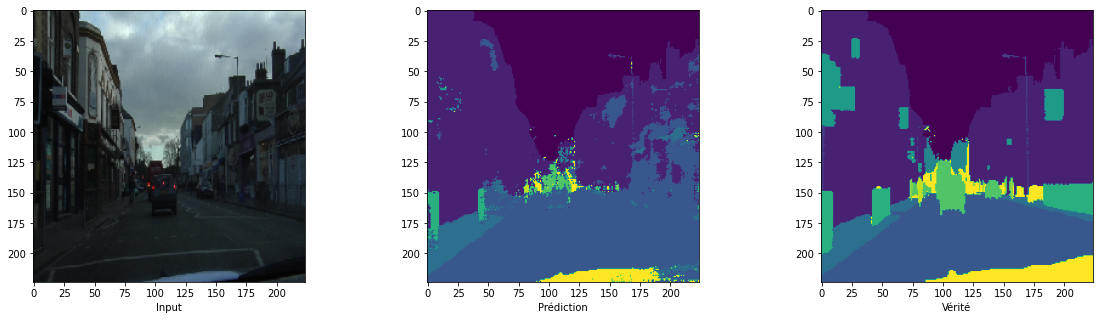

In [0]:
num_obs=150

img = tf.reshape(x_train[num_obs], (-1, 224, 224, 3))
p = model2.predict(img)
p = np.argmax(p, axis=-1)
p.shape

figsize(20, 5)

subplot(1, 3, 1)
imshow(img[0, :, : ,:])
xlabel('Input')

subplot(1, 3, 2)
imshow(p[0, :, :])
xlabel('Prédiction')

subplot(1, 3, 3)
imshow(y_train[num_obs][:, :])
xlabel('Vérité')

m = tf.keras.metrics.MeanIoU(num_classes=32)
m(y_train[num_obs][:, :], p[0, :, :]).numpy()

##### FC-Densenet67

- 67 layers (FC-DenseNet67) with $5$ layers per dense block and a growth rate of $16$.

In [0]:
#fc-densenet 67
filters = 16
nb_blocks = 5
nb_layers = [5, 5, 5, 5, 5 ,5, 5, 5, 5, 5, 5]
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()
model = FCDensenet(filters, nb_layers, img_shape, num_classes=32)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 48) 1344        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 48) 192         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 224, 224, 48) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [0]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=keras.optimizers.RMSprop(lr=1e-3),
              metrics=["accuracy"])

In [0]:
model.fit(ds,
          epochs=2)